In [1]:
targetFolderHBK = r"H:\Extracted_Features\HBK\HBK_14285Hz_original_all_features\features"
targetFolderMCC5 = r"H:\Extracted_Features\MCC5\MCC5_12800Hz_original_all_features_motor_vibration_x\features"
targetFolderSIZA = r"H:\Extracted_Features\SIZA\SIZA_original_all_features\features"
normalization_method = "z_score"

In [2]:
experiment_name = "augmented_data_analysis_binary_best_features"
project_name="augmented_data_analysis_binary_best_features",
run_name="augmented_data_analysis_binary_best_features"
domain="all"

domains_to_use = ['time', 'frequency', 'time-frequency']

In [3]:
binary_classification=True
plot_histograms_choice=False
include_augmentations=True

# Environment Setup & Imports

In [4]:
import os
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle
import numpy as np
import mlflow
from pytorch_lightning.loggers import MLFlowLogger
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, hamming_loss, hinge_loss, jaccard_score, log_loss, precision_score, recall_score, f1_score, make_scorer
from pathlib import Path
from pycaret.classification import * 
from torch import tensor
from torchmetrics.classification import BinaryAccuracy, MulticlassAccuracy
import optuna
import torch
from sklearn.model_selection import train_test_split
from pytorch_tabular import TabularModel
from pytorch_tabular.models import GANDALFConfig, CategoryEmbeddingModel,GatedAdditiveTreeEnsembleConfig, NodeConfig, FTTransformerConfig, TabNetModelConfig
from pytorch_tabular.config import (
    DataConfig,
    OptimizerConfig,
    ModelConfig,
    TrainerConfig,
    ExperimentConfig,
)
from collections import Counter
from data_loader import load_feature_data

## Helper Functions

In [5]:
def select_features_by_domain(domains: list, available_features: dict = None) -> list:
    """
    Selects a list of features based on the specified domains.

    Args:
        domains: A list of domain names (e.g., ['time', 'frequency']).
        available_features: A dictionary mapping domain names (keys) to 
                            lists of features (values). If None, uses a 
                            default dictionary.

    Returns:
        A flat list of all selected features.
    """
    # Define the complete feature set structure
    if available_features is None:
        available_features = {
            'time': ['rms', 'std', 'crest', 'energy', 'entropy'],
            'frequency': ['meanFreq', 'medianFreq', 'spectral_entropy', 'spectral_skewness'],
            # Assuming 'Time-Frequency' is referred to by a simpler domain name, 
            # or you can keep the full name
            'time-frequency': ['meanWavelet', 'varWavelet', 'entropyWavelet', 'entropySpectrogram']
        }

    selected_features = []
    
    # Iterate over the requested domains and extend the list
    for domain in domains:
        # Convert domain to lowercase for case-insensitive matching
        domain_key = domain.lower().replace('_', '-').strip()
        
        if domain_key in available_features:
            selected_features.extend(available_features[domain_key])
        else:
            print(f"Warning: Domain '{domain}' not recognized in available features.") # Optional warning

    # Return only unique features in case of overlap (though unlikely here)
    return list(set(selected_features))

In [6]:
features_to_include = select_features_by_domain(domains=domains_to_use)

In [7]:
def plotHistograms(dataframe, normalization):
    for col in dataframe.columns:
        if col == "Label":
            continue
        plt.figure(figsize=(8, 4))
        sns.histplot(data = dataframe, x=col, hue='Label', kde=True, multiple='layer', element='step', alpha=0.5)
        plt.title(f"Distribution of {col} with {normalization}")
        plt.show()

In [8]:
def normalizeDataframe(dataframe, normalization_method):
    """
    Normalizes the features of a dataframe using a specified method.

    Args:
        dataframe (pd.DataFrame): The input dataframe with a 'Label' column.
        normalization_method (str): The method to use ("min_max", "z_score", "robust_scaling").

    Returns:
        pd.DataFrame: The dataframe with scaled features.
    """
    # Separate features (X) and the target variable (y)
    y = dataframe['Label']
    X = dataframe.drop(columns=['Label'])

    # Select the scaler based on the chosen method
    if normalization_method == "min_max":
        scaler = MinMaxScaler()
    elif normalization_method == "z_score":
        scaler = StandardScaler()
    elif normalization_method == "robust_scaling":
        scaler = RobustScaler()
    else:
        # Raise an error for an invalid method name
        raise ValueError(f"Unknown normalization_method: '{normalization_method}'")

    # Fit the scaler to the data and transform it
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X),
        columns=X.columns,
        index=X.index
    )

    # Rejoin the scaled features with the label column
    df_scaled = X_scaled.join(y)
    
    return df_scaled

In [9]:
def plotPredictionHistograms(df, normalization):
    # 1) mark correct vs incorrect
    df = df.copy()
    df['prediction_quality'] = np.where(
        df['Label'] == df['prediction_label'],
        'correct',
        'incorrect'
    )
    
    # 2) choose a palette (you can override these colors if you like)
    pal = dict(zip(
        ['correct','incorrect'],
        sns.color_palette(n_colors=2)
    ))
    
    skip = {'Label','prediction_label','prediction_score','prediction_quality'}
    for col in df.columns:
        if col in skip:
            continue
        
        fig, ax = plt.subplots(figsize=(8,4))
        sns.histplot(
            data=df, x=col, hue='prediction_quality',
            palette=pal,
            kde=True, multiple='layer', element='step',
            alpha=0.5,
            ax=ax
        )
        
        # 3) build a manual legend using the same palette
        handles = [
            mpatches.Patch(color=pal[k], label=k)
            for k in ['correct','incorrect']
        ]
        ax.legend(
            handles=handles,
            title='Prediction Quality'
        )
        
        ax.set_title(
            f"Distribution of {col}\n"
            f"(normalization = '{normalization}')"
        )
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
        plt.tight_layout()
        plt.show()

In [10]:
def get_incorrect_predictions(df):
    return df[
        ((df['Label'] == 'damaged')   & (df['prediction_label'] == 'healthy'))
      | ((df['Label'] == 'healthy')  & (df['prediction_label'] == 'damaged'))
    ].copy()

In [11]:
def get_feature_importance_df(model, df):
    importance = model.feature_importances_
    n = len(importance)
    features = df.columns[:n]
    fi_df = pd.DataFrame({
        'Features': features,
        'importance': importance
    })
    return fi_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

In [12]:
def get_svm_feature_importance_df(model, df):
    if not hasattr(model, 'coef_'):
        raise ValueError("This SVM model has no coefficients. Use a linear kernel.")
    
    importance = model.coef_.ravel()  # Flatten in case of binary classification
    n = len(importance)
    features = df.columns[:n]
    fi_df = pd.DataFrame({
        'Features': features,
        'importance': abs(importance)
    })
    return fi_df.sort_values(by='importance', ascending=False).reset_index(drop=True)


In [13]:
feature_counter = Counter()
def add_top_features(feature_df: pd.DataFrame, top_n: int):
    top_features = feature_df.nlargest(top_n, 'importance')['Features']
    feature_counter.update(top_features)
    
def plot_feature_importance():
    feature_freq = pd.DataFrame(feature_counter.items(), columns=['Feature', 'Count'])
    plt.figure(figsize=(10, 5))
    sns.barplot(data=feature_freq.sort_values(by='Count', ascending=False),
                x='Feature', y='Count')
    plt.xticks(rotation=45)
    plt.title('Feature Frequency Across Experiments')
    plt.tight_layout()
    plt.show()

In [14]:
def save_feature_counter(exp_name: str, folder: str = f"top_features_{experiment_name}"):
    os.makedirs(folder, exist_ok=True)
    filepath = os.path.join(folder, f"{exp_name}_features.csv")
    df = pd.DataFrame(feature_counter.items(), columns=['Feature', 'Count'])
    df.to_csv(filepath, index=False)

## Import Dataset

In [15]:
df_HBK = load_feature_data(
    features_path=targetFolderHBK,
    include_augmentations=include_augmentations,      # Only 'original' data
    include_speed_torque=False,       # Drop operating conditions
    binary_classification=binary_classification,       # 'healthy' vs 'damaged'
    features_to_include=features_to_include
)

Successfully loaded 966 files into a DataFrame with shape (1140403, 30)
Applied binary classification: 'healthy' vs 'damaged'.
Selected specific features: ['entropy', 'meanWavelet', 'spectral_skewness', 'meanFreq', 'entropySpectrogram', 'entropyWavelet', 'rms', 'std', 'energy', 'spectral_entropy', 'medianFreq', 'varWavelet', 'crest']
Dropped 'Speed' and 'Torque' columns.
Final DataFrame shape: (1140403, 14)


In [16]:
df_SIZA = load_feature_data(
    features_path=targetFolderMCC5,
    include_augmentations=include_augmentations,      # Only 'original' data
    include_speed_torque=False,       # Drop operating conditions
    binary_classification=binary_classification,       # 'healthy' vs 'damaged'
    features_to_include=features_to_include
)

Successfully loaded 216 files into a DataFrame with shape (307368, 30)
Applied binary classification: 'healthy' vs 'damaged'.
Selected specific features: ['entropy', 'meanWavelet', 'spectral_skewness', 'meanFreq', 'entropySpectrogram', 'entropyWavelet', 'rms', 'std', 'energy', 'spectral_entropy', 'medianFreq', 'varWavelet', 'crest']
Dropped 'Speed' and 'Torque' columns.
Final DataFrame shape: (307368, 14)


In [17]:
df_MCC5 = load_feature_data(
    features_path=targetFolderMCC5,
    include_augmentations=include_augmentations,      # Only 'original' data
    include_speed_torque=False,       # Drop operating conditions
    binary_classification=binary_classification,       # 'healthy' vs 'damaged'
    features_to_include=features_to_include
)

Successfully loaded 216 files into a DataFrame with shape (307368, 30)
Applied binary classification: 'healthy' vs 'damaged'.
Selected specific features: ['entropy', 'meanWavelet', 'spectral_skewness', 'meanFreq', 'entropySpectrogram', 'entropyWavelet', 'rms', 'std', 'energy', 'spectral_entropy', 'medianFreq', 'varWavelet', 'crest']
Dropped 'Speed' and 'Torque' columns.
Final DataFrame shape: (307368, 14)


In [18]:
combined_df = pd.concat([df_HBK, df_SIZA, df_MCC5], ignore_index=True)

In [19]:
normalized_df = normalizeDataframe(combined_df, normalization_method)

In [20]:
features_df_training_normalized, features_df_testing_normalized = train_test_split(
    normalized_df, 
    test_size=0.2,    # e.g., 20% for testing
    random_state=42   # for reproducibility
)

# Histograms

## Histograms Training and Testing [NO-Normalization]

In [21]:
if (plot_histograms_choice):
    plotHistograms(combined_df, normalization_method)

## Histograms Training and Testing [Z-Score Normalization]

In [22]:
if (plot_histograms_choice):
    plotHistograms(normalized_df, normalization_method)

# Experiment Setup (ML)

## Setup Hyperparameters

In [23]:
experiment = setup(features_df_training_normalized, target='Label', log_experiment = True, experiment_name = experiment_name, use_gpu = True)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Quadro P620, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split 

,Description,Value
0,Session id,7711
1,Target,Label
2,Target type,Binary
3,Target mapping,"damaged: 0, healthy: 1"
4,Original data shape,"(1404111, 14)"
5,Transformed data shape,"(1404111, 14)"
6,Transformed train set shape,"(982877, 14)"
7,Transformed test set shape,"(421234, 14)"
8,Numeric features,13
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Quadro P620, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split 

Traceback (most recent call last):
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1341, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1334, in _read_hel

In [24]:
experiment.y_test

1201582    damaged
1686544    damaged
740180     damaged
1060056    damaged
903370     damaged
            ...   
206468     damaged
537079     damaged
1405433    damaged
480747     damaged
303465     damaged
Name: Label, Length: 421234, dtype: category
Categories (2, object): ['damaged', 'healthy']

## Add aditional metrics

In [25]:
# Binary classification metrics
add_metric('balanced_acc', 'Balance Acc', balanced_accuracy_score, target='pred', greater_is_better=True)
add_metric('hamming_loss', 'Hamming Loss', hamming_loss, target='pred', greater_is_better=False)
add_metric('jaccard_score', 'Jaccard Score', jaccard_score, target='pred', greater_is_better=True)
add_metric('log_loss', 'Log Loss', log_loss, target='pred_proba', greater_is_better=False)

Name                                                          Log Loss
Display Name                                                  Log Loss
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer               make_scorer(log_loss, greater_is_better=False,...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: log_loss, dtype: object

In [26]:
all_metrics = get_metrics()
all_metrics

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x000002009CC4F2E0>,accuracy,pred,{},True,True,False
auc,AUC,AUC,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(roc_auc_score, response_method=('d...",pred_proba,"{'average': 'weighted', 'multi_class': 'ovr'}",True,True,False
recall,Recall,Recall,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(recall_score, response_method='pre...",pred,{'average': 'weighted'},True,True,False
precision,Precision,Prec.,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(precision_score, response_method='...",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(f1_score, response_method='predict...",pred,{'average': 'weighted'},True,True,False
kappa,Kappa,Kappa,<function cohen_kappa_score at 0x000002009CC4F...,"make_scorer(cohen_kappa_score, response_method...",pred,{},True,True,False
mcc,MCC,MCC,<function matthews_corrcoef at 0x000002009CC4F...,"make_scorer(matthews_corrcoef, response_method...",pred,{},True,True,False
balanced_acc,Balance Acc,Balance Acc,<pycaret.internal.metrics.EncodedDecodedLabels...,"make_scorer(balanced_accuracy_score, response_...",pred,{},True,True,True
hamming_loss,Hamming Loss,Hamming Loss,<pycaret.internal.metrics.EncodedDecodedLabels...,"make_scorer(hamming_loss, greater_is_better=Fa...",pred,{},False,True,True


## Light Gradient Boosting Machine

In [27]:
bestParamsLIGHTGBM = {
    'bagging_fraction': 0.8455104741417432,
    'bagging_freq': 0,
    'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': 1.0,
    'device': 'gpu',
    'feature_fraction': 0.42947671039481,
    'importance_type': 'split',
    'learning_rate': 0.47910287588557177,
    'max_depth': -1,
    'min_child_samples': 41,
    'min_child_weight': 0.001,
    'min_split_gain': 0.23016472358397666,
    'n_estimators': 245,
    'n_jobs': -1,
    'num_leaves': 250,
    'objective': None,
    'random_state': 1768,
    'reg_alpha': 0.00039695268896179983,
    'reg_lambda': 3.6071600095045767e-06,
    'subsample': 1.0,
    'subsample_for_bin': 200000,
    'subsample_freq': 0
}


In [28]:
lightgbm = create_model('lightgbm', **bestParamsLIGHTGBM)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balance Acc,Hamming Loss,Jaccard Score,Log Loss
Fold,,,,,,,,,,,
0,0.8886,0.8333,0.8886,0.8848,0.8852,0.6625,0.6662,0.8131,0.1114,0.5776,2.7108
1,0.9210,0.8970,0.9210,0.9195,0.9185,0.7603,0.7648,0.8587,0.0790,0.6802,1.5426
2,0.9234,0.9179,0.9234,0.9218,0.9219,0.7725,0.7742,0.8725,0.0766,0.6965,1.4367
3,0.9180,0.9047,0.9180,0.9164,0.9169,0.7589,0.7598,0.8696,0.0820,0.6823,1.6748
4,0.8150,0.7917,0.8150,0.8358,0.8222,0.5164,0.5230,0.7829,0.1850,0.4688,5.3305
5,0.9116,0.9014,0.9116,0.9099,0.9104,0.7402,0.7410,0.8608,0.0884,0.6620,1.8716
6,0.9332,0.9473,0.9332,0.9324,0.9327,0.8057,0.8061,0.8966,0.0668,0.7369,1.1162
7,0.8859,0.8548,0.8859,0.8849,0.8853,0.6701,0.6702,0.8319,0.1141,0.5916,2.8289
8,0.9216,0.9406,0.9216,0.9222,0.9219,0.7771,0.7772,0.8914,0.0784,0.7063,1.5125


Traceback (most recent call last):
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1341, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1334, in _read_hel

[LightGBM] [Warning] feature_fraction is set=0.42947671039481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42947671039481
[LightGBM] [Warning] bagging_fraction is set=0.8455104741417432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8455104741417432
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.42947671039481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42947671039481
[LightGBM] [Warning] bagging_fraction is set=0.8455104741417432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8455104741417432
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


2025/10/07 17:56:32 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [29]:
evaluate_model(lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [30]:
lightgbm_top_features = get_feature_importance_df(lightgbm, features_df_training_normalized)
lightgbm_top_features

,Features,importance
0,spectral_skewness,8182
1,crest,6541
2,meanFreq,6152
3,medianFreq,5383
4,entropyWavelet,5088
5,meanWavelet,4533
6,entropySpectrogram,4419
7,entropy,4287
8,spectral_entropy,3981
9,varWavelet,3960


In [31]:
add_top_features(lightgbm_top_features, top_n=3)

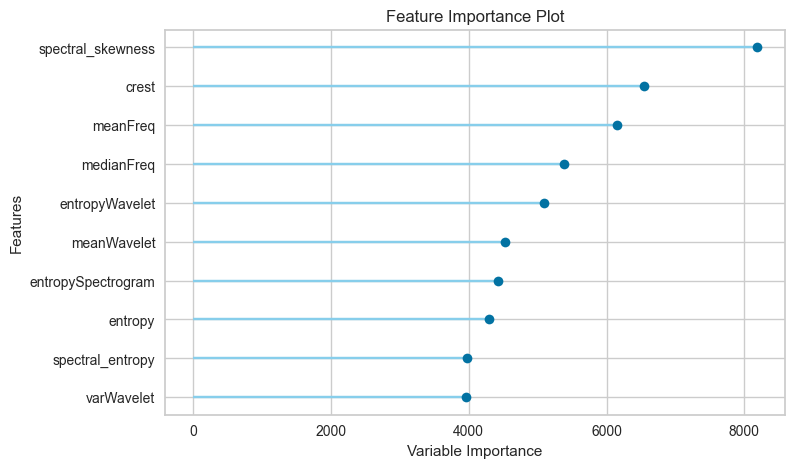

In [32]:
plot_model(lightgbm, plot='feature')

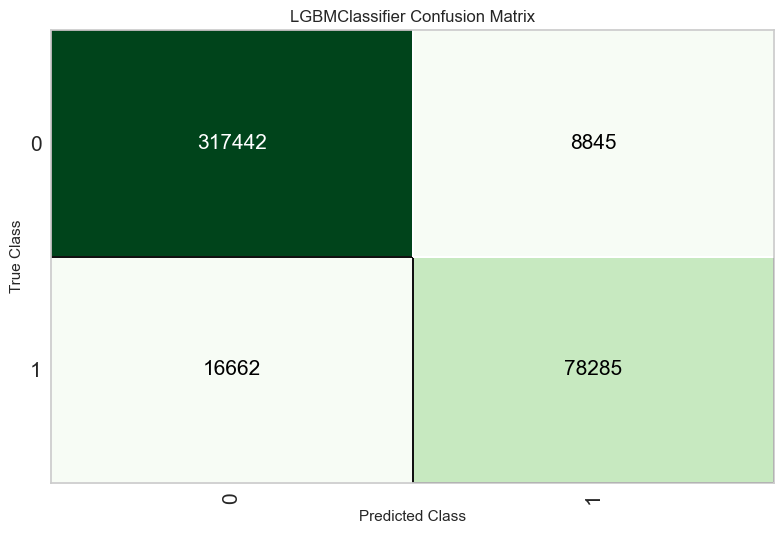

In [33]:
plot_model(lightgbm, plot='confusion_matrix')

In [34]:
predictions_lightgbm = predict_model(lightgbm, data = features_df_testing_normalized)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balance Acc,Hamming Loss,Jaccard Score,Log Loss
0,Light Gradient Boosting Machine,0.9393,0.9510,0.9393,0.9383,0.9384,0.8208,0.8220,0.8986,0.0607,0.7535,0.8779


[LightGBM] [Warning] feature_fraction is set=0.42947671039481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42947671039481
[LightGBM] [Warning] bagging_fraction is set=0.8455104741417432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8455104741417432
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.42947671039481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42947671039481
[LightGBM] [Warning] bagging_fraction is set=0.8455104741417432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8455104741417432
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


In [35]:
predictions_lightgbm

,entropy,meanWavelet,spectral_skewness,meanFreq,entropySpectrogram,entropyWavelet,rms,std,energy,spectral_entropy,medianFreq,varWavelet,crest,Label,prediction_label,prediction_score
1575777,0.177634,-0.304672,-0.054910,-0.238901,-0.145942,0.176429,-0.273183,-0.276917,-0.212540,-0.342074,-0.299985,-0.238003,0.359123,damaged,damaged,0.9387
269280,0.175282,-0.565767,-0.151251,1.291922,-0.146138,0.160634,-0.457678,-0.477689,-0.228239,-0.422729,1.329778,-0.263216,-0.297836,healthy,healthy,1.0000
891733,0.174260,-0.548117,0.029424,-0.934762,-0.146150,0.157745,-0.497980,-0.529957,-0.230144,-0.430026,-1.376331,-0.269985,0.002615,damaged,damaged,1.0000
210511,0.173942,-0.609123,1.073048,0.391798,-0.146150,0.156943,-0.511436,-0.536242,-0.230658,-0.433343,0.346671,-0.268224,-0.772699,damaged,damaged,1.0000
845522,0.167901,0.237824,-0.461564,1.494547,-0.144796,0.202841,0.102069,0.131564,-0.145268,-0.001064,2.041633,-0.135619,1.464663,damaged,damaged,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121923,0.173038,-0.648183,0.781657,0.235601,-0.146153,0.154243,-0.552289,-0.580818,-0.231846,-0.439390,-0.151413,-0.270479,-0.591739,damaged,damaged,1.0000
1427683,0.151400,0.436876,0.321843,-0.208992,-0.136921,0.177855,0.299339,0.346429,-0.090900,0.148764,-0.255930,-0.021847,-0.168177,damaged,healthy,1.0000
554972,0.172860,-0.669434,0.171408,0.456792,-0.146153,0.153603,-0.561135,-0.590694,-0.232029,-0.441303,0.823009,-0.270640,0.106472,healthy,healthy,1.0000
673674,0.173264,0.057689,0.199591,0.506370,-0.145353,0.200031,-0.009165,0.010606,-0.170151,-0.172193,0.361646,-0.167029,0.068274,damaged,damaged,1.0000


In [36]:
get_incorrect_predictions(predictions_lightgbm)

,entropy,meanWavelet,spectral_skewness,meanFreq,entropySpectrogram,entropyWavelet,rms,std,energy,spectral_entropy,medianFreq,varWavelet,crest,Label,prediction_label,prediction_score
1347639,0.178219,-0.320828,-1.745364,-0.451932,-0.146056,0.178550,-0.303285,-0.309686,-0.215884,-0.349665,-0.232984,-0.243124,-0.063727,damaged,healthy,0.6178
1469143,0.163794,0.312264,-0.171211,0.239400,-0.143114,0.205981,0.133188,0.165565,-0.137562,0.036532,-0.246850,-0.124273,-0.166642,healthy,damaged,0.5894
225015,0.176621,-0.461356,0.058833,1.149574,-0.146130,0.167420,-0.409407,-0.425160,-0.225238,-0.406516,1.695815,-0.259220,-0.904592,damaged,healthy,1.0000
48592,0.172532,-0.697843,0.671989,0.295251,-0.146153,0.152578,-0.582086,-0.613486,-0.232358,-0.442962,-0.438104,-0.271180,-0.043709,healthy,damaged,1.0000
1490854,0.176753,-0.478540,-0.379099,-0.657845,-0.146045,0.166242,-0.377451,-0.390541,-0.222820,-0.380452,-0.298310,-0.252661,0.051109,healthy,damaged,0.8352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1703217,0.163295,0.311526,0.096369,-0.094059,-0.141266,0.195883,0.173742,0.209686,-0.127030,0.040523,-0.253148,-0.090523,0.078045,damaged,healthy,0.7723
1547912,0.176383,-0.002829,-0.993828,-0.659004,-0.145222,0.198217,-0.066453,-0.051818,-0.181341,-0.171274,-0.271053,-0.184123,0.367098,damaged,healthy,0.5330
1511463,0.158562,0.364879,0.217482,-0.164376,-0.139498,0.188826,0.232249,0.273334,-0.110860,0.103794,-0.253584,-0.059173,0.245386,damaged,healthy,1.0000
64378,0.172267,-0.727637,0.667817,-0.651265,-0.146153,0.151816,-0.606164,-0.639767,-0.232554,-0.444626,-1.484337,-0.271495,0.527082,healthy,damaged,0.9743


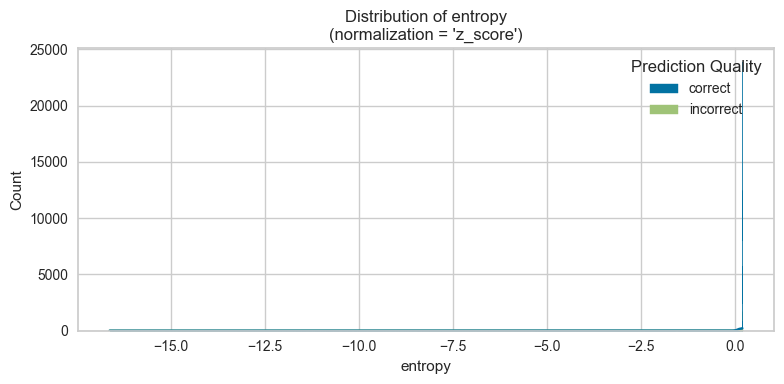

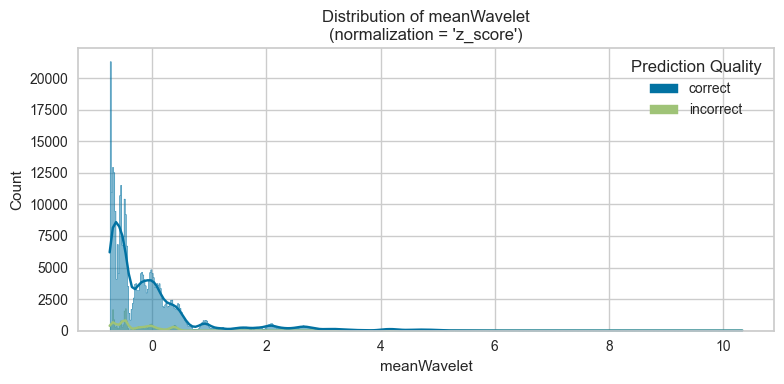

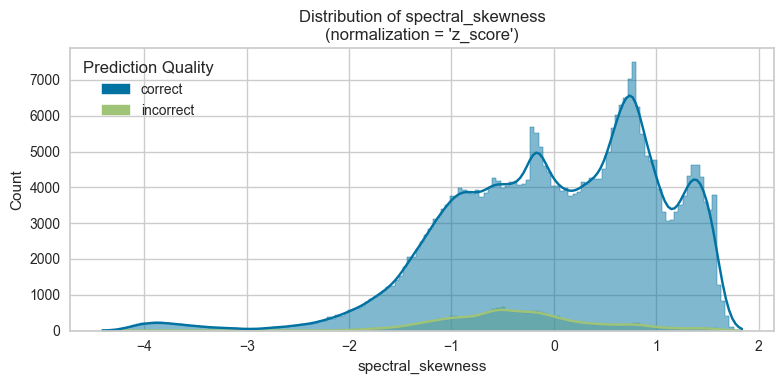

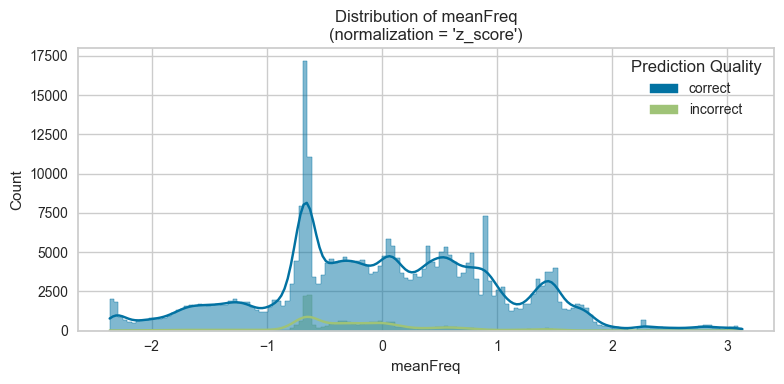

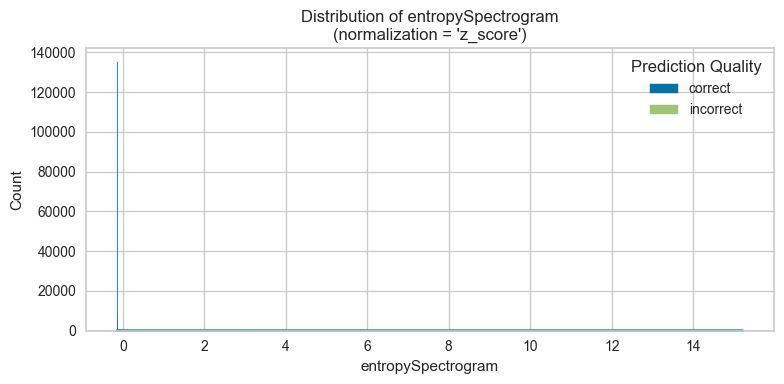

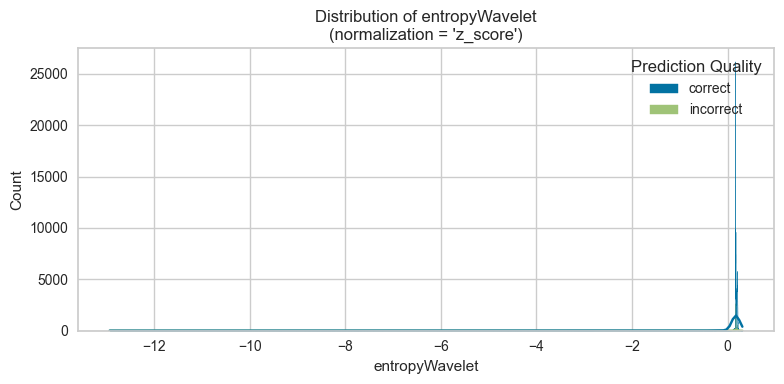

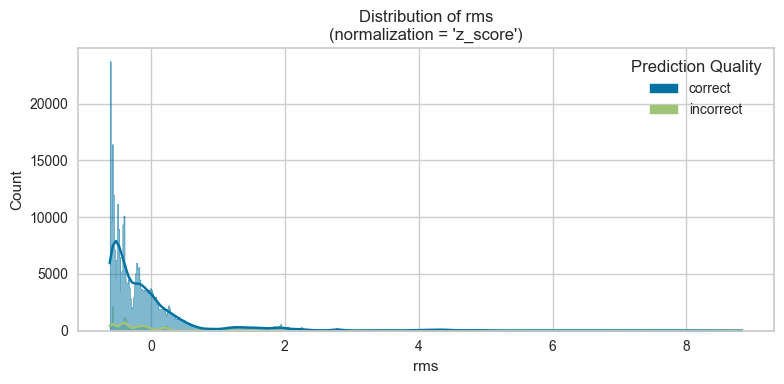

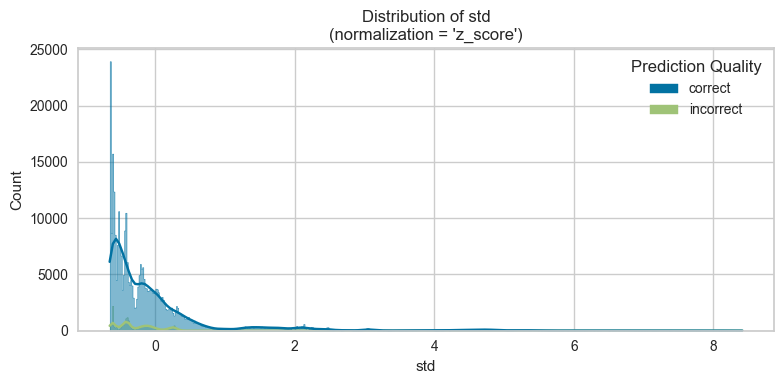

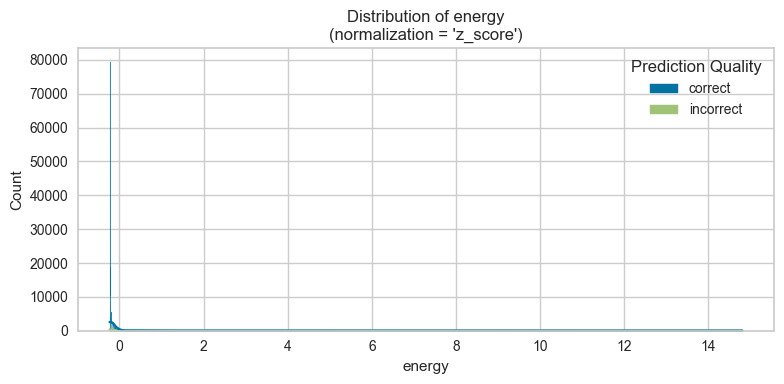

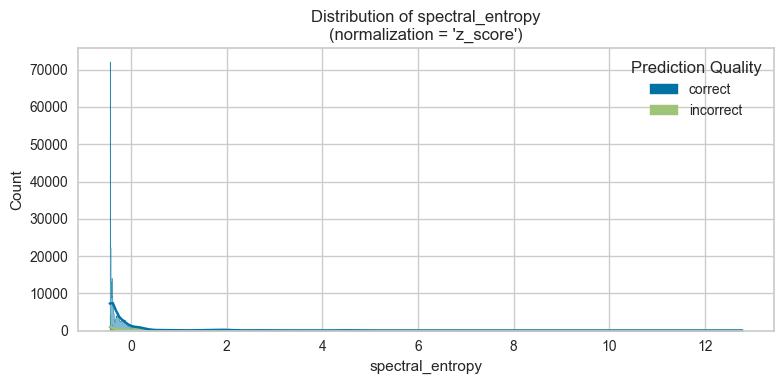

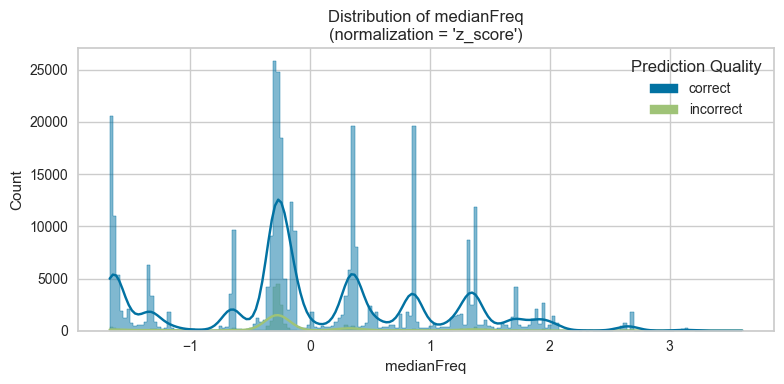

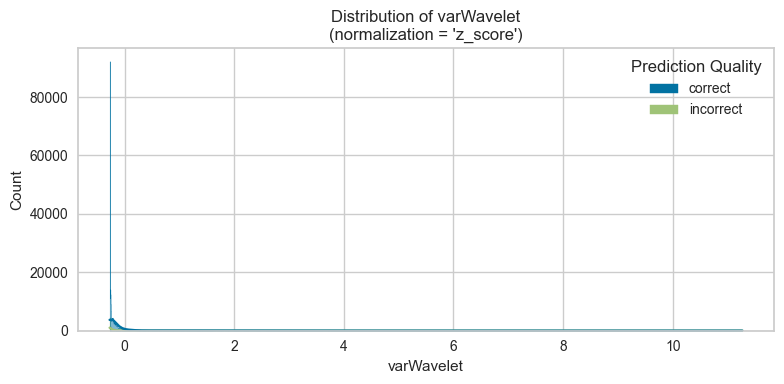

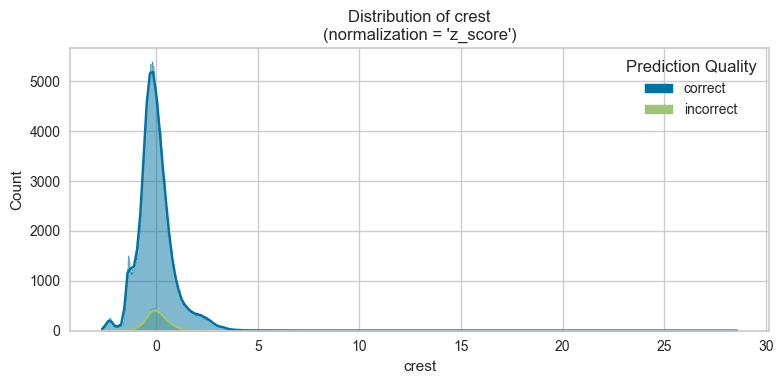

In [37]:
plotPredictionHistograms(predictions_lightgbm, normalization_method)

## Random Forest Classifier

In [38]:
bestParamsRF = {
    'bootstrap':True, 
    'ccp_alpha':0.0, 
    'class_weight':None,
    'criterion':'gini', 
    'max_depth':None, 
    'max_features':'sqrt',
    'max_leaf_nodes':None, 
    'max_samples':None,
    'min_impurity_decrease':0.0, 
    'min_samples_leaf':1,
    'min_samples_split':2, 
    'min_weight_fraction_leaf':0.0,
    'monotonic_cst':None, 
    'n_estimators':100, 
    'n_jobs':-1,
    'oob_score':False, 
    'random_state':1768, 
    'verbose':False,
    'warm_start':False
}

In [39]:
rf = create_model('rf', **bestParamsRF)

Traceback (most recent call last):
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1341, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1334, in _read_hel

In [40]:
evaluate_model(rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [41]:
rf_top_features = get_feature_importance_df(rf, features_df_training_normalized)
rf_top_features

,Features,importance
0,meanWavelet,0.172195
1,medianFreq,0.137875
2,spectral_entropy,0.093041
3,meanFreq,0.084096
4,energy,0.072478
5,spectral_skewness,0.070888
6,rms,0.066792
7,std,0.066693
8,entropyWavelet,0.058068
9,varWavelet,0.055631


In [42]:
add_top_features(rf_top_features, top_n=3)

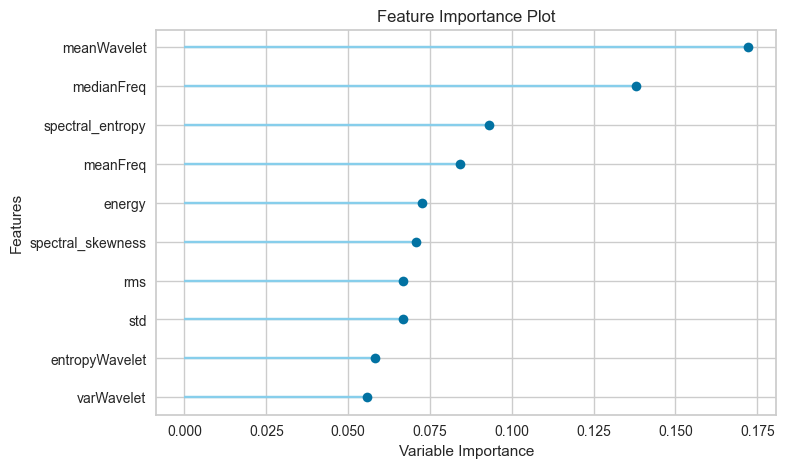

In [43]:
plot_model(rf, plot='feature')

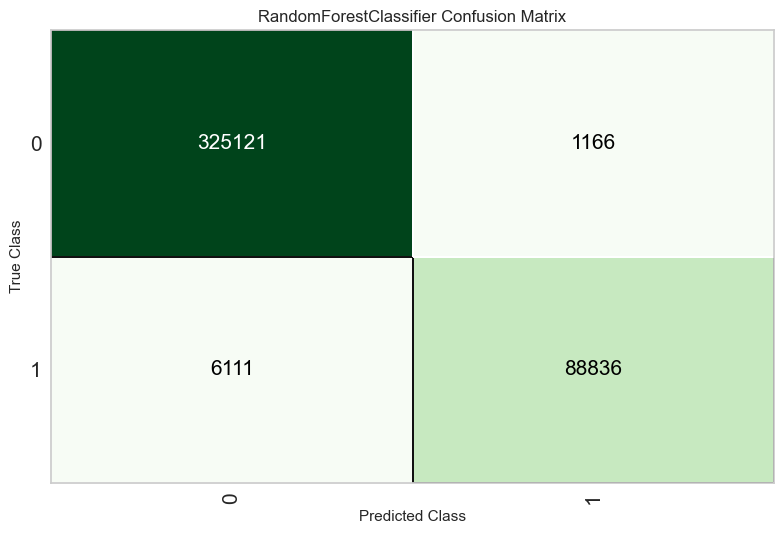

In [44]:
plot_model(rf, plot='confusion_matrix')

In [45]:
predictions_rf = predict_model(rf, data = features_df_testing_normalized)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balance Acc,Hamming Loss,Jaccard Score,Log Loss
0,Random Forest Classifier,0.9824,0.9973,0.9824,0.9825,0.9822,0.9486,0.9492,0.9655,0.0176,0.9228,0.0621


In [46]:
get_incorrect_predictions(predictions_rf)

,entropy,meanWavelet,spectral_skewness,meanFreq,entropySpectrogram,entropyWavelet,rms,std,energy,spectral_entropy,medianFreq,varWavelet,crest,Label,prediction_label,prediction_score
1469143,0.163794,0.312264,-0.171211,0.239400,-0.143114,0.205981,0.133188,0.165565,-0.137562,0.036532,-0.246850,-0.124273,-0.166642,healthy,damaged,0.50
1180498,0.176819,-0.481008,-0.232229,0.109752,-0.146089,0.166304,-0.373620,-0.386371,-0.222507,-0.386558,0.315803,-0.251828,-0.163782,healthy,damaged,0.60
1183544,0.176630,-0.479827,-0.466801,-0.655568,-0.146067,0.165873,-0.378416,-0.391625,-0.222898,-0.388462,-0.289184,-0.252810,0.125651,healthy,damaged,0.60
1166343,0.158630,0.420004,-0.474833,0.243966,-0.142459,0.209697,0.182472,0.219184,-0.124690,0.061213,-0.262200,-0.113050,0.212457,healthy,damaged,0.64
1486637,0.169430,0.122982,0.043020,0.733939,-0.143098,0.189286,0.104295,0.133960,-0.144728,-0.053754,0.355597,-0.130764,-0.191690,healthy,damaged,0.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178567,0.178517,-0.205044,-0.471613,0.741419,-0.145708,0.184901,-0.157662,-0.151147,-0.196879,-0.239372,0.424723,-0.209752,0.015557,healthy,damaged,0.83
1166672,0.160309,0.305290,-0.049010,0.212256,-0.142162,0.200934,0.137669,0.170463,-0.136425,0.060671,-0.259804,-0.125227,0.421851,healthy,damaged,0.77
1159281,0.176493,-0.452597,-0.401501,-0.363289,-0.146085,0.167058,-0.378038,-0.391162,-0.222867,-0.385679,-0.284544,-0.254389,0.181537,healthy,damaged,0.65
1703217,0.163295,0.311526,0.096369,-0.094059,-0.141266,0.195883,0.173742,0.209686,-0.127030,0.040523,-0.253148,-0.090523,0.078045,damaged,healthy,0.70


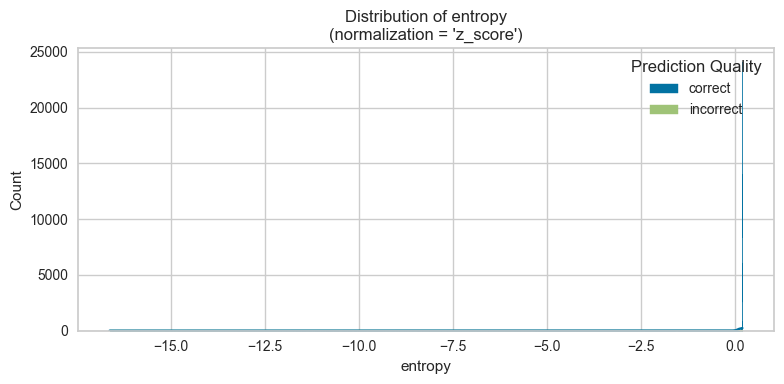

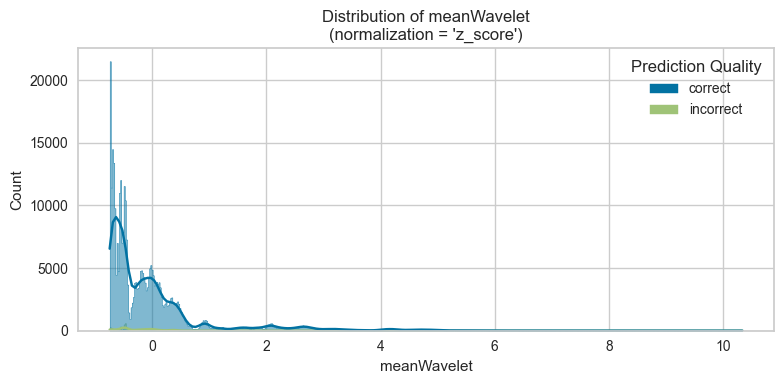

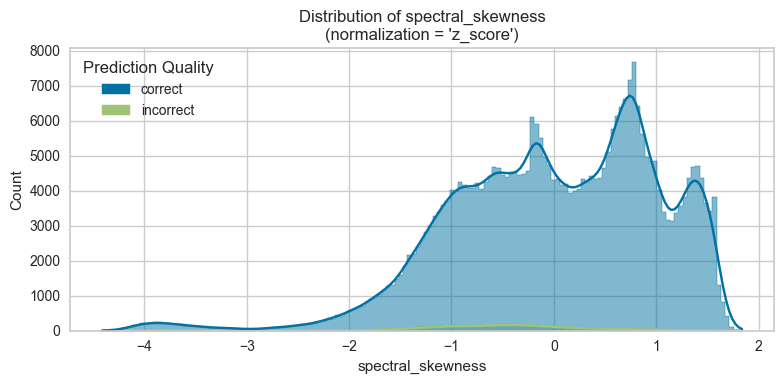

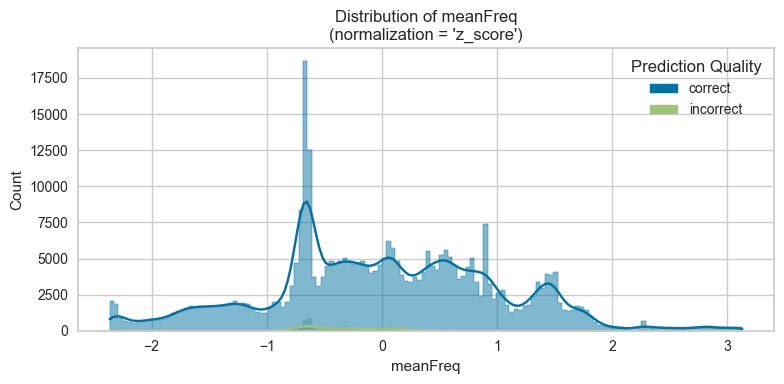

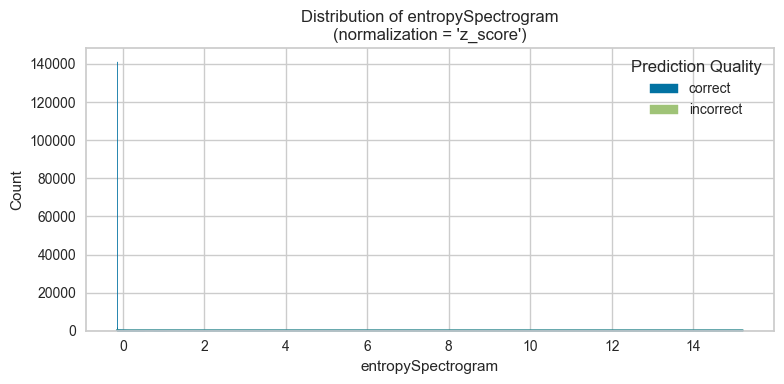

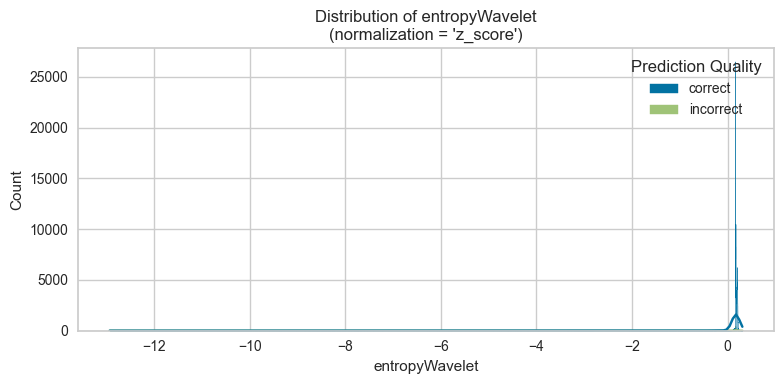

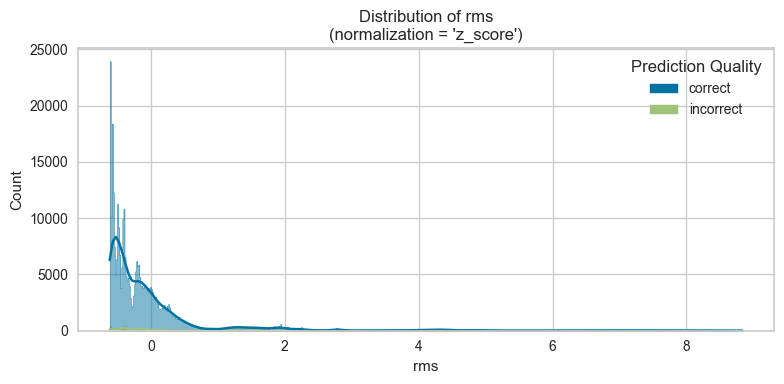

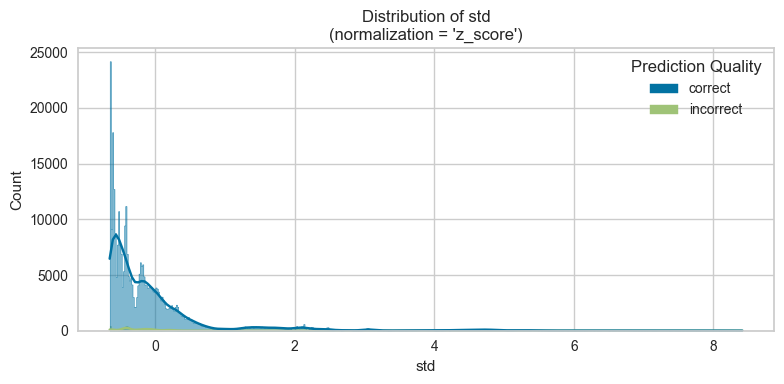

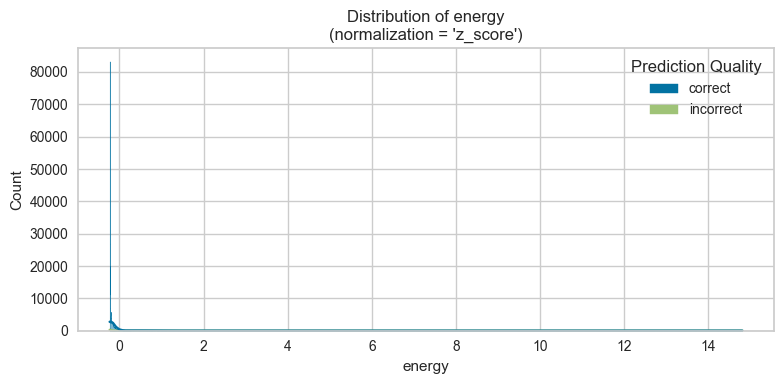

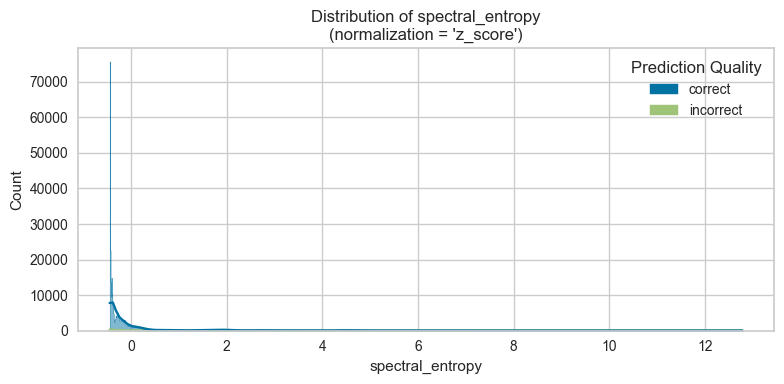

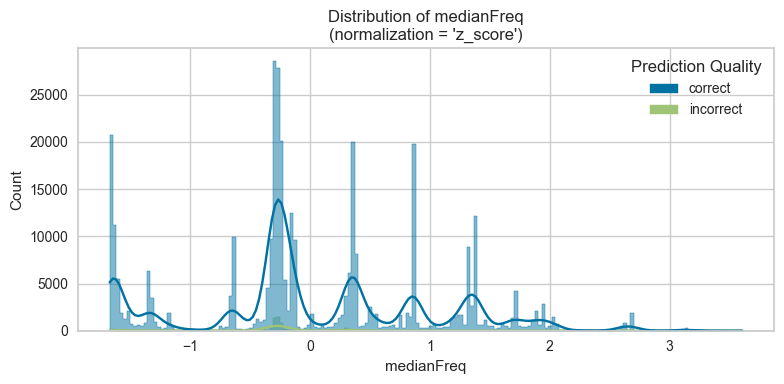

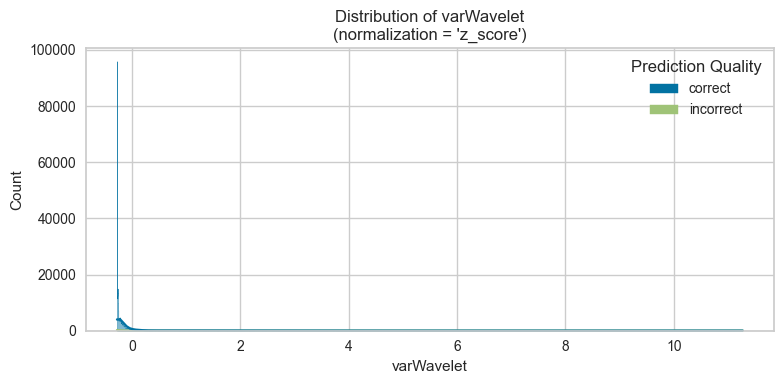

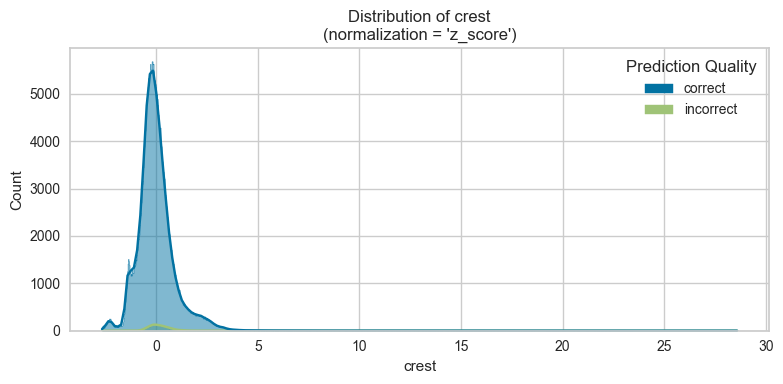

In [47]:
plotPredictionHistograms(predictions_rf, normalization_method)

## SVM

In [48]:
bestParamsSVM = {
    'alpha':1.983570694577895e-06, 
    'average':False, 
    'class_weight':None,
    'early_stopping':False, 
    'epsilon':0.1, 
    'eta0':0.050879465480455605,
    'fit_intercept':True, 
    'l1_ratio':0.3264919553269943,
    'learning_rate':'adaptive', 
    'loss':'hinge', 
    'max_iter':1000,
    'n_iter_no_change':5, 
    'n_jobs':-1, 
    'penalty':'l2', 
    'power_t':0.5,
    'random_state':1768, 
    'shuffle':True, 
    'tol':0.001,
    'validation_fraction':0.1, 
    'verbose':False, 
    'warm_start':False
}

In [49]:
svm = create_model('svm', **bestParamsSVM)

Traceback (most recent call last):
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1341, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1334, in _read_hel

In [50]:
evaluate_model(svm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

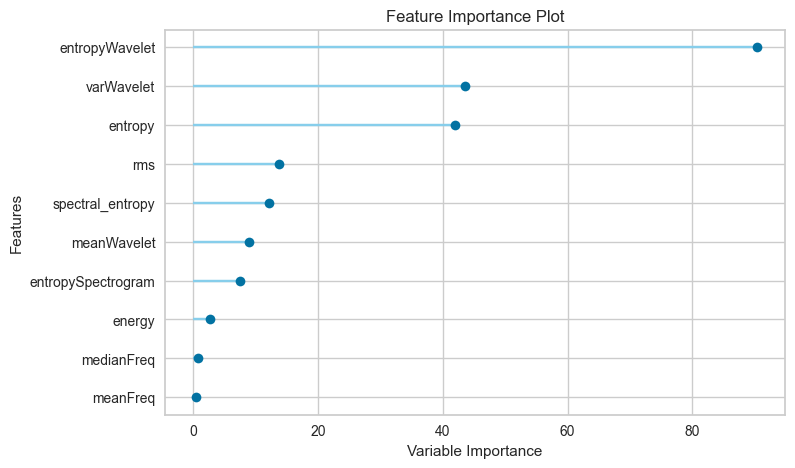

In [51]:
plot_model(svm, plot='feature')

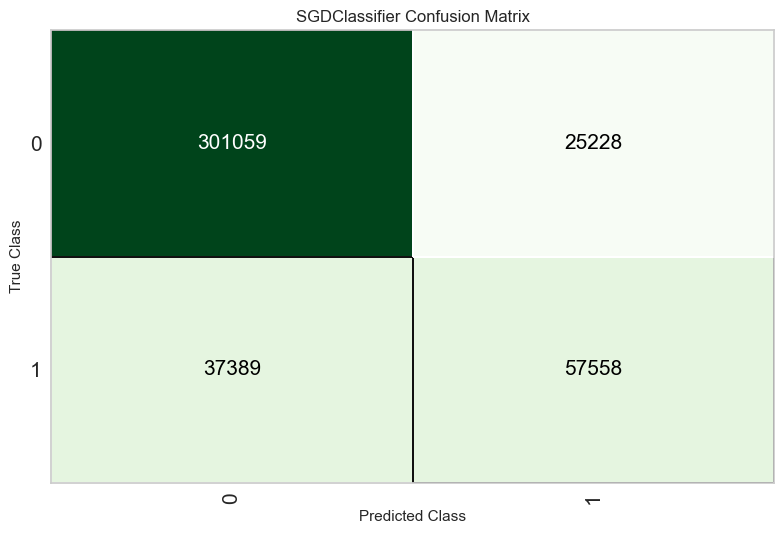

In [52]:
plot_model(svm, plot='confusion_matrix')

In [53]:
predictions_svm = predict_model(svm, data=features_df_testing_normalized)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balance Acc,Hamming Loss,Jaccard Score,Log Loss
0,SVM - Linear Kernel,0.8513,0,0.8513,0.8457,0.8476,0.5534,0.5554,0.7641,0.1487,0.4782,0


In [54]:
get_incorrect_predictions(predictions_svm)

,entropy,meanWavelet,spectral_skewness,meanFreq,entropySpectrogram,entropyWavelet,rms,std,energy,spectral_entropy,medianFreq,varWavelet,crest,Label,prediction_label
269280,0.175282,-0.565767,-0.151251,1.291922,-0.146138,0.160634,-0.457678,-0.477689,-0.228239,-0.422729,1.329778,-0.263216,-0.297836,healthy,damaged
574471,0.172248,-0.733292,0.352024,-0.279060,-0.146153,0.151776,-0.609411,-0.642905,-0.232566,-0.444737,-1.389571,-0.271498,0.267180,damaged,healthy
1469143,0.163794,0.312264,-0.171211,0.239400,-0.143114,0.205981,0.133188,0.165565,-0.137562,0.036532,-0.246850,-0.124273,-0.166642,healthy,damaged
447873,0.174041,-0.604720,-0.080663,1.258581,-0.146149,0.156991,-0.508183,-0.532691,-0.230539,-0.432151,1.327858,-0.267979,-0.331018,healthy,damaged
272347,0.175308,-0.560830,-0.170739,1.268304,-0.146137,0.160768,-0.455443,-0.475255,-0.228117,-0.422104,1.329693,-0.263088,-0.706939,healthy,damaged
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556125,0.172796,-0.659381,-0.231168,-1.352840,-0.146153,0.153241,-0.564023,-0.598284,-0.232083,-0.440713,-1.353009,-0.271186,1.424856,healthy,damaged
45617,0.175361,-0.582847,1.082052,0.794044,-0.146141,0.160276,-0.465484,-0.486221,-0.228650,-0.424238,0.764320,-0.263824,-1.443931,healthy,damaged
111017,0.174341,-0.577959,-0.211476,1.325338,-0.146149,0.158217,-0.492701,-0.515986,-0.229925,-0.427373,1.329787,-0.267314,-0.365942,healthy,damaged
1479823,0.176583,-0.480481,-0.381090,-0.612712,-0.146084,0.165961,-0.390552,-0.404771,-0.223853,-0.386577,-0.272009,-0.255094,0.249848,healthy,damaged


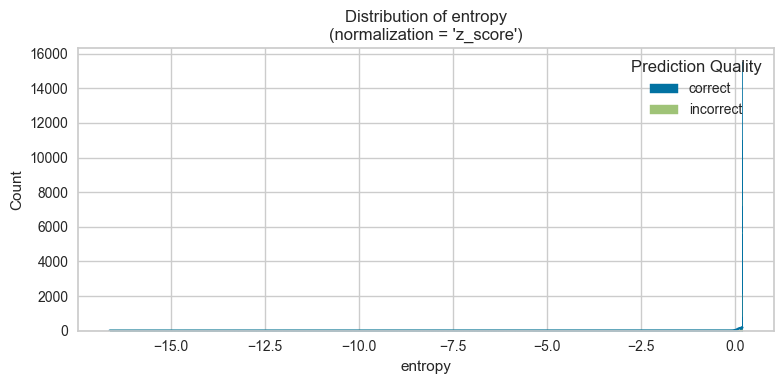

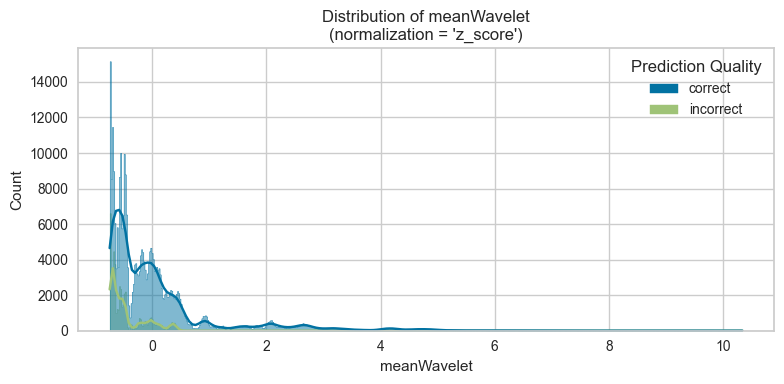

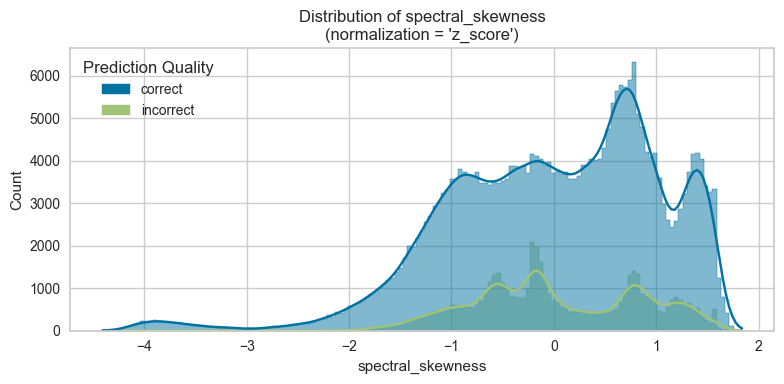

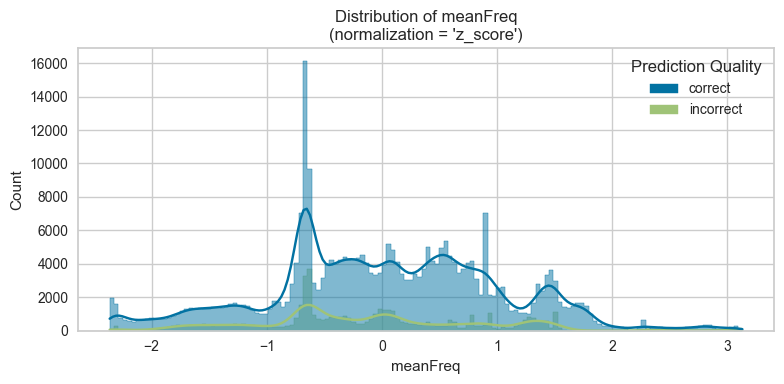

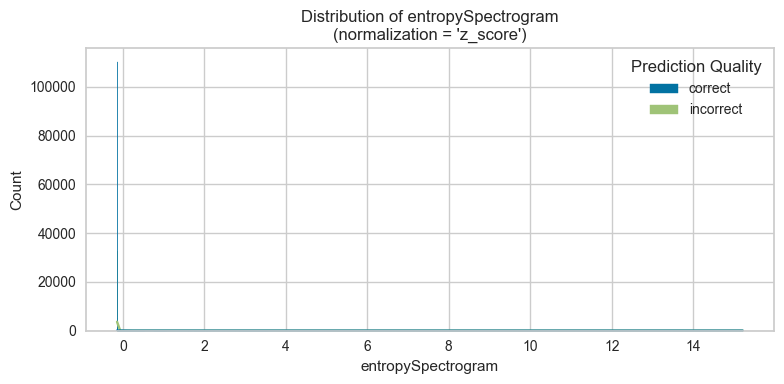

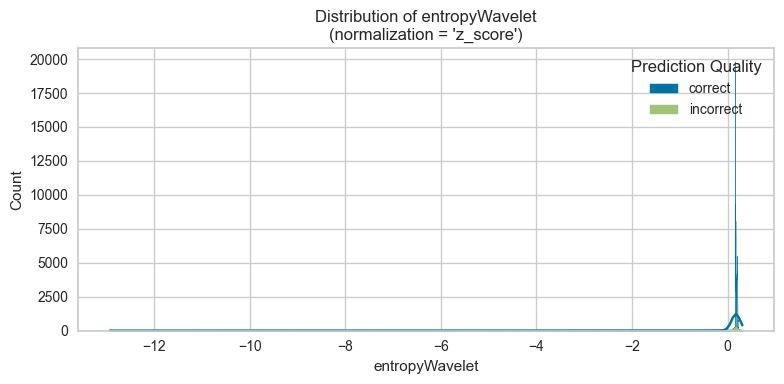

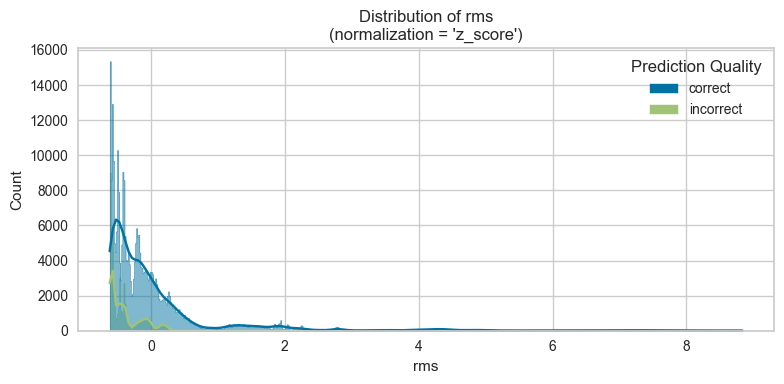

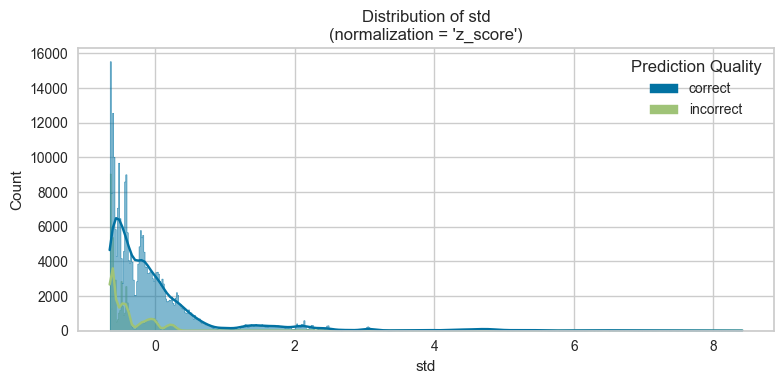

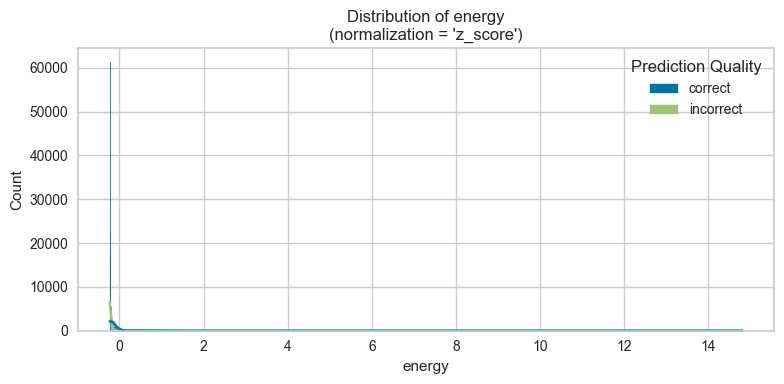

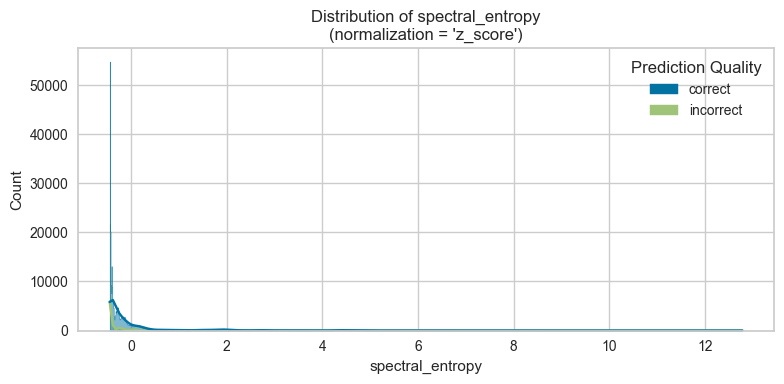

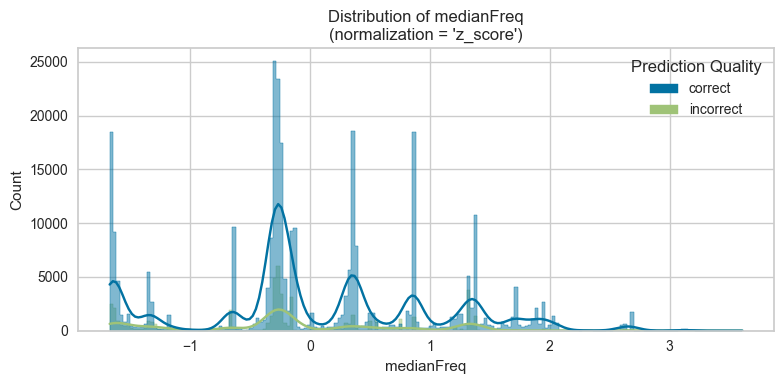

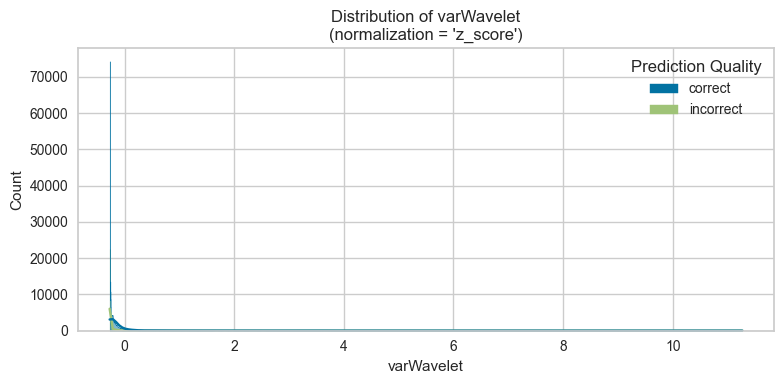

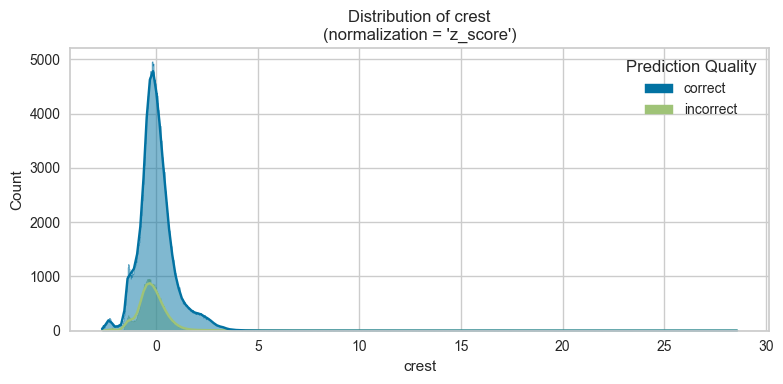

In [55]:
plotPredictionHistograms(predictions_svm, normalization_method)

# Experiment Setup (DL)

## Configure Data

In [56]:
train, test = train_test_split(normalized_df, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)
print(f"Train Shape: {train.shape} | Val Shape: {val.shape} | Test Shape: {test.shape}")

Train Shape: (1123288, 14) | Val Shape: (280823, 14) | Test Shape: (351028, 14)


In [57]:
target = "Label"
num_labels = normalized_df['Label'].nunique()

categorical_cols = [
    col
    for col in features_df_training_normalized.select_dtypes(include=["object","category"]).columns
    if col != target
]

continuous_cols = features_df_training_normalized.select_dtypes(include=["number"]).columns.tolist()

In [58]:
print("Target:", target)
print("Categorical inputs:", categorical_cols)  
print("Continuous inputs:", continuous_cols)    

Target: Label
Categorical inputs: []
Continuous inputs: ['entropy', 'meanWavelet', 'spectral_skewness', 'meanFreq', 'entropySpectrogram', 'entropyWavelet', 'rms', 'std', 'energy', 'spectral_entropy', 'medianFreq', 'varWavelet', 'crest']


In [59]:
data_config = DataConfig(
    target=[target],
    continuous_cols=continuous_cols,
    categorical_cols=categorical_cols,
)

In [60]:
available_gpu=1 if torch.cuda.is_available() else 0
print(f"Available GPU: {'Yes' if available_gpu else 'No'}")

Available GPU: Yes


In [61]:
trainer_config = TrainerConfig(
    auto_lr_find=False,
    max_epochs=10,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    batch_size=256,
)

optimizer_config = OptimizerConfig()

experiment_config = ExperimentConfig(
        project_name=experiment_name,
        run_name=f"{experiment_name}_run",
        log_target="tensorboard",
    )

In [62]:
tabnet_config = TabNetModelConfig(
        task="classification",
        n_d=33,
        n_a=46,
        n_steps=3,
        gamma=1.2864230491528987,
        embedding_dropout=0.1825276618254278,
        learning_rate=0.00468046516266798,
        metrics=[
            "accuracy", 
            "auroc",
            "recall",
            "precision",
            "f1_score",
            "cohen_kappa",
            "matthews_corrcoef",
            "hamming_distance",
            "jaccard_index",
        ],
        metrics_prob_input=[
            False,  #acc
            True,   # auroc
            False,  # recall
            False,  # precision
            False,  # f1_score
            False,  # cohen_kappa
            False,  # matthews_corrcoef
            False,  # hamming_distance
            False,  # jaccard_index
        ],
        metrics_params=[
            {"average": "macro"},
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # auroc
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # recall
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # precision
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # f1_score
            {"num_classes": normalized_df['Label'].nunique()},                      # cohen_kappa
            {},                                      # matthews_corrcoef
            {},                                      # hamming_distance
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # jaccard_index
        ]
    )

In [63]:
tabnet_model = TabularModel(
        data_config=data_config,
        model_config=tabnet_config,
        optimizer_config=optimizer_config,
        trainer_config=trainer_config,
        verbose=True
    )

2025-10-07 18:22:50,909 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

In [64]:
tabnet_model.fit(train=train, validation=val)

Seed set to 42


2025-10-07 18:22:50,966 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-10-07 18:22:51,098 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-10-07 18:22:51,828 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: TabNetModel

2025-10-07 18:22:51,969 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-10-07 18:22:52,063 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _embedding_layer │ Identity         │      0 │ train │
│ 1 │ _backbone        │ TabNetBackbone   │  121 K │ train │
│ 2 │ _head            │ Identity         │      0 │ train │
│ 3 │ loss             │ CrossEntropyLoss │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 121 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 121 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 107                                                                                         
Modules in eval mode: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


2025-10-07 19:27:56,943 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-10-07 19:27:56,945 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

In [65]:
tabnet_pred_df = tabnet_model.predict(test)
tabnet_pred_df.head(10)
tabnet_result = tabnet_model.evaluate(test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9263392090797424     │
│        test_auroc         │    0.9652590751647949     │
│     test_cohen_kappa      │    0.7669025659561157     │
│       test_f1_score       │    0.9263392090797424     │
│   test_hamming_distance   │    0.07366079092025757    │
│    test_jaccard_index     │    0.7986245155334473     │
│         test_loss         │    0.17692936956882477    │
│        test_loss_0        │    0.17692936956882477    │
│  test_matthews_corrcoef   │    0.7801239490509033     │
│      test_precision       │    0.9263392090797424     │
│        test_recall        │    0.9263392090797424     │
└───────────────────────────┴───────────────────────────┘

## GANDALF

In [66]:
gandalf_config = GANDALFConfig(
        task="classification",
        gflu_stages=8,
        gflu_dropout=0.20621973444441227,
        gflu_feature_init_sparsity=0.5069371167197942,
        learnable_sparsity=False,
        embedding_dropout= 0.06647823724375934,
        batch_norm_continuous_input=False,
        learning_rate=2.6124262014312122e-05,
        metrics=[
            "accuracy", 
            "auroc",
            "recall",
            "precision",
            "f1_score",
            "cohen_kappa",
            "matthews_corrcoef",
            "hamming_distance",
            "jaccard_index",
        ],
        metrics_prob_input=[
            False,  #acc
            True,   # auroc
            False,  # recall
            False,  # precision
            False,  # f1_score
            False,  # cohen_kappa
            False,  # matthews_corrcoef
            False,  # hamming_distance
            False,  # jaccard_index
        ],
        metrics_params=[
            {"average": "macro"},
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # auroc
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # recall
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # precision
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # f1_score
            {"num_classes": normalized_df['Label'].nunique()},                      # cohen_kappa
            {},                                      # matthews_corrcoef
            {},                                      # hamming_distance
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # jaccard_index
        ]
    )

In [67]:
gandalf_model = TabularModel(
    data_config=data_config,
    model_config=gandalf_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
    verbose=True
)

2025-10-07 19:29:44,687 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

In [68]:
gandalf_model.fit(train=train, validation=val)

Seed set to 42


2025-10-07 19:29:44,773 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-10-07 19:29:44,921 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-10-07 19:29:45,719 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-10-07 19:29:45,860 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-10-07 19:29:45,978 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  8.5 K │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │      0 │ train │
│ 2 │ _head            │ Sequential       │     30 │ train │
│ 3 │ loss             │ CrossEntropyLoss │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 8.6 K                                                                                            
Non-trainable params: 8                                                                                            
Total params: 8.6 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 30                                                                                          
Modules in eval mode: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


2025-10-07 20:27:02,900 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-10-07 20:27:02,902 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

In [69]:
gandalf_pred_df = gandalf_model.predict(test)
gandalf_pred_df.head(10)

,Label_damaged_probability,Label_healthy_probability,Label_prediction
1575777,0.882916,0.117084,damaged
269280,0.237920,0.762080,healthy
891733,0.886697,0.113303,damaged
210511,0.715558,0.284442,damaged
845522,0.990122,0.009878,damaged
1082755,0.965423,0.034577,damaged
1715124,0.817786,0.182214,damaged
1059125,0.906977,0.093023,damaged
1281366,0.854350,0.145650,damaged
1347639,0.804841,0.195159,damaged


In [70]:
gandalf_result = gandalf_model.evaluate(test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8824880123138428     │
│        test_auroc         │    0.8769444823265076     │
│     test_cohen_kappa      │    0.6036167144775391     │
│       test_f1_score       │    0.8824880123138428     │
│   test_hamming_distance   │    0.11751199513673782    │
│    test_jaccard_index     │    0.6858875751495361     │
│         test_loss         │    0.32273486256599426    │
│        test_loss_0        │    0.32273486256599426    │
│  test_matthews_corrcoef   │    0.6359714269638062     │
│      test_precision       │    0.8824880123138428     │
│        test_recall        │    0.8824880123138428     │
└───────────────────────────┴───────────────────────────┘

In [71]:
gandalf_top_features = gandalf_model.feature_importance().sort_values("importance", ascending=False)
gandalf_top_features

,Features,importance
2,spectral_skewness,1.530389
1,meanWavelet,1.288574
3,meanFreq,0.789415
6,rms,0.595765
11,varWavelet,0.581731
12,crest,0.539128
0,entropy,0.488397
8,energy,0.402120
5,entropyWavelet,0.397555
4,entropySpectrogram,0.367372


In [72]:
add_top_features(gandalf_top_features, top_n=3)

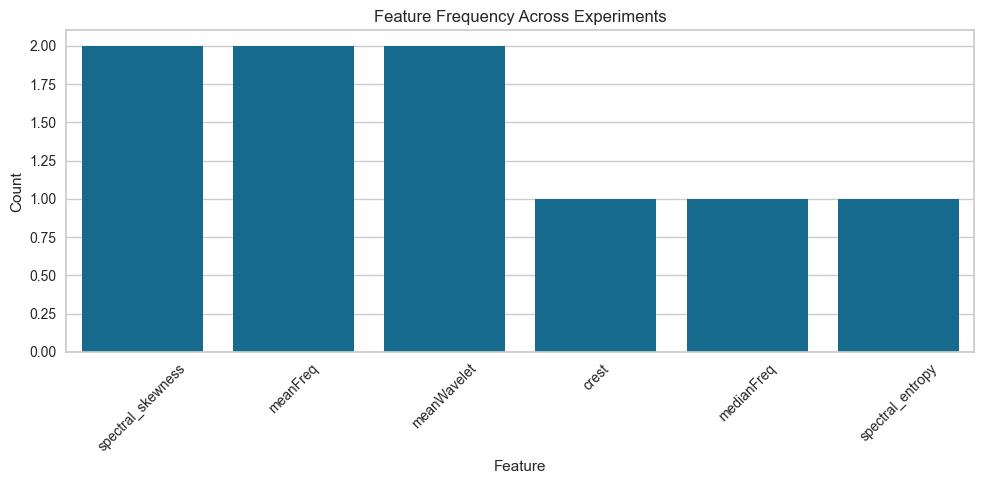

In [73]:
plot_feature_importance()